In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [48]:
import pandas as pd

# path_to_files = "/content/drive/MyDrive/recommender_system_files/"
path_to_files = "./recommender_system_files/"
ratings = pd.read_csv(path_to_files + "ratings.csv", sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv(path_to_files + "movies.csv", sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [6]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [8]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [10]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [11]:
# mapping movie titles to indices
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()
def genre_recommendations(title, n=10):
    index = indices[title]  # index of our movie
    sim_scores = list(enumerate(cosine_sim[index])) # similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1] # starting from 1 so that the movie itself doesn't come to number 1
    movie_indices = [i[0] for i in sim_scores]
    
    return movies[['title', 'genres']].iloc[movie_indices]

In [12]:
# Example
genre_recommendations('GoldenEye (1995)')

,title,genres
345,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
543,Surviving the Game (1994),"['Action', 'Adventure', 'Thriller']"
724,"Rock, The (1996)","['Action', 'Adventure', 'Thriller']"
788,Daylight (1996),"['Action', 'Adventure', 'Thriller']"
825,Chain Reaction (1996),"['Action', 'Adventure', 'Thriller']"
978,Maximum Risk (1996),"['Action', 'Adventure', 'Thriller']"
1467,Anaconda (1997),"['Action', 'Adventure', 'Thriller']"
1513,Con Air (1997),"['Action', 'Adventure', 'Thriller']"
1693,Firestorm (1998),"['Action', 'Adventure', 'Thriller']"
3686,"Perfect Storm, The (2000)","['Action', 'Adventure', 'Thriller']"



### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
data = pd.merge(ratings, movies, on='movie_id')

In [15]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,1,661,3,0,660,James and the Giant Peach (1996),"['Animation', ""Children's"", 'Musical']"
2,1,914,3,0,913,My Fair Lady (1964),"['Musical', 'Romance']"
3,1,3408,4,0,3407,Erin Brockovich (2000),['Drama']
4,1,2355,5,0,2354,"Bug's Life, A (1998)","['Animation', ""Children's"", 'Comedy']"


In [16]:
# data = data.assign(genres=data['genres'].str.split('|')).explode('genres')
# ensuring genres column is a list
data['genres'] = data['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# splitting genres column into separate rows
data = data.explode('genres')

In [17]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,0,660,James and the Giant Peach (1996),Animation
1,1,661,3,0,660,James and the Giant Peach (1996),Children's
1,1,661,3,0,660,James and the Giant Peach (1996),Musical
2,1,914,3,0,913,My Fair Lady (1964),Musical


In [18]:
total_user_movie_counts = data.groupby('user_id').size().reset_index(name='total_movies')
total_user_genres_counts = data.groupby(['user_id','genres']).size().reset_index(name='total_genres')

user_genre_df = pd.merge(total_user_movie_counts, total_user_genres_counts, on=['user_id'], how='left')
user_genre_df['genre_proportion'] = user_genre_df['total_genres'] / user_genre_df['total_movies']

user_genre_df.head(5)

,user_id,total_movies,genres,total_genres,genre_proportion
0,1,116,Action,5,0.043103
1,1,116,Adventure,5,0.043103
2,1,116,Animation,18,0.155172
3,1,116,Children's,20,0.172414
4,1,116,Comedy,14,0.120690


In [19]:
#and now that we have proportion of each genre to all movies
user_genre_matrix = user_genre_df.pivot(index='user_id', columns='genres', values='genre_proportion')
user_genre_matrix = user_genre_matrix.fillna(0)
user_genre_matrix.head(5)


genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,0.043103,0.043103,0.155172,0.172414,0.120690,0.017241,0.000000,0.181034,0.025862,0.000000,0.000000,0.120690,0.000000,0.051724,0.025862,0.025862,0.017241,0.000000
2,0.194444,0.065972,0.000000,0.000000,0.086806,0.041667,0.000000,0.274306,0.003472,0.003472,0.006944,0.000000,0.010417,0.083333,0.059028,0.107639,0.052083,0.010417
3,0.186992,0.203252,0.024390,0.024390,0.243902,0.000000,0.000000,0.065041,0.016260,0.000000,0.024390,0.008130,0.008130,0.040650,0.048780,0.040650,0.016260,0.048780
4,0.327586,0.103448,0.000000,0.017241,0.000000,0.017241,0.000000,0.103448,0.034483,0.000000,0.051724,0.000000,0.000000,0.034483,0.155172,0.068966,0.051724,0.034483
5,0.088068,0.025568,0.011364,0.017045,0.159091,0.059659,0.017045,0.295455,0.000000,0.008523,0.028409,0.008523,0.022727,0.085227,0.042614,0.110795,0.017045,0.002841


In [20]:
def get_top_n_similar_users(user_id, n=5):
    user_preferences = user_genre_matrix.loc[user_id].values.reshape(1,-1)
    similarities = cosine_similarity(user_genre_matrix, user_preferences)
    similar_users = similarities.flatten().argsort()[::-1][1:n+1]   # excluding user itself
    return similar_users + 1

get_top_n_similar_users(1, 5)

array([4456, 1481, 4767, 5343, 4883], dtype=int64)

In [21]:

def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    #TODO
    similar_users = get_top_n_similar_users(user_id, n_similar_users)
    similar_users_data = data[data['user_id'].isin(similar_users)]
    target_user_data = data[data['user_id']==user_id]
    target_user_movies = set(target_user_data['movie_id'])

    similar_users_movies = similar_users_data[~similar_users_data['movie_id'].isin(target_user_movies)]

    all_recommended_movies = similar_users_movies.groupby('movie_id').size().reset_index(name='count')
    
    top_recommended_movies = all_recommended_movies.sort_values(by='count', ascending=False)[:n_recommendations]
    
    top_movies = pd.merge(top_recommended_movies, movies, on='movie_id', how='left')[['movie_id', 'title', 'genres']]

    return top_movies.sort_values(by="movie_id")


In [22]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)
recommended_movies


,movie_id,title,genres
8,34,Babe (1995),"[""Children's"", 'Comedy', 'Drama']"
9,912,Casablanca (1942),"['Drama', 'Romance', 'War']"
3,1032,Alice in Wonderland (1951),"['Animation', ""Children's"", 'Musical']"
7,1282,Fantasia (1940),"['Animation', ""Children's"", 'Musical']"
2,1617,L.A. Confidential (1997),"['Crime', 'Film-Noir', 'Mystery', 'Thriller']"
4,2078,"Jungle Book, The (1967)","['Animation', ""Children's"", 'Comedy', 'Musical']"
1,2080,Lady and the Tramp (1955),"['Animation', ""Children's"", 'Comedy', 'Musical..."
0,2081,"Little Mermaid, The (1989)","['Animation', ""Children's"", 'Comedy', 'Musical..."
5,2087,Peter Pan (1953),"['Animation', ""Children's"", 'Fantasy', 'Musical']"
6,2096,Sleeping Beauty (1959),"['Animation', ""Children's"", 'Musical']"


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [23]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [24]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
# Ratings.head()

In [25]:
# calculate rating matrix
ratings_matrix = Ratings.to_numpy()

In [26]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(ratings_matrix, k=50)
sigma = np.diag(sigma)

In [27]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)


In [28]:
preds = pd.DataFrame(all_user_predicted_ratings, columns=Ratings.columns)
# predictions.head()

In [29]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)

    user_data = original_ratings[original_ratings.user_id == userID]

    # merge movies data with user_data
    user_full = user_data.merge(movies, on='movie_id', how='left').sort_values(['rating'], ascending=False)
    
    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = movies[~movies['movie_id'].isin(user_full['movie_id'])]
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(),on='movie_id', how='left')
    recommendations = recommendations.rename(columns={user_row_number: "Predictions"}).sort_values(by='Predictions', ascending=False)
    
    return user_full, recommendations


In [30]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [31]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [32]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),['Drama']
285,4375,175,5,4374,174,Kids (1995),['Drama']
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)","['Action', 'Drama', 'Romance', 'Thriller']"
65,4375,3809,5,4374,3808,What About Bob? (1991),['Comedy']
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)","['Drama', 'Thriller']"
270,4375,150,5,4374,149,Apollo 13 (1995),['Drama']
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",['Horror']
125,4375,349,5,4374,348,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
60,4375,288,5,4374,287,Natural Born Killers (1994),"['Action', 'Thriller']"
141,4375,47,5,4374,46,Seven (Se7en) (1995),"['Crime', 'Thriller']"


#### Evaluation

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=40)

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train, axis=1)
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(Ratings_demeaned_train, k=50)
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1, 1)

preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    try:
        user_row_number = user_id - 1  # User ID starts at 1, not 0
        prediction = preds_train.iloc[user_row_number, movie_id]
    except:
        prediction = np.nan
    return prediction

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 3.5301000025783873


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [34]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [127]:
ratings = pd.read_csv(path_to_files + "ratings.csv", sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
movies = pd.read_csv(path_to_files + "movies.csv", sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])
user_id_map = {id: idx for idx, id in enumerate(ratings['user_id'].unique())}
movie_id_map = {id: idx for idx, id in enumerate(ratings['movie_id'].unique())}
ratings['user_id'] = ratings['user_id'].map(user_id_map)
ratings['movie_id'] = ratings['movie_id'].map(movie_id_map)

# Define the dataset
class RatingsDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        self.users = torch.tensor(ratings['user_id'].values, dtype=torch.long)
        self.movies = torch.tensor(ratings['movie_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['rating'].values, dtype=torch.float)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        #TODO
        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.movie_embeddings = nn.Embedding(num_movies, embedding_size)
        self.layers = nn.Sequential(
            nn.Linear(embedding_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.bn = nn.BatchNorm1d(embedding_size * 2) # embedding of both user and movie are of the same size
        
    def forward(self, user, movie):
        user_embedding = self.user_embeddings(user)
        movie_embedding = self.movie_embeddings(movie)
        concated_embeddings = self.bn(torch.cat([user_embedding, movie_embedding], dim=1))
        out = self.layers(concated_embeddings)
        return out.view(-1)

# Create the dataset and dataloader
# only using first 100 000 ratings to decrease training time
ratings = ratings[:100000]
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=40)
train_dataset = RatingsDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = RatingsDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function and optimizer
num_users = ratings['user_id'].nunique() 
num_movies = ratings['movie_id'].nunique() 
model = RecommenderNet(num_users, num_movies, embedding_size=50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_criterion = nn.MSELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    loss = 0.0
    for users, movies, ratings in train_dataloader:
        optimizer.zero_grad()
        # print(f"users is {users}")
        # print(f"movies is {movies}")
        out = model(users, movies).squeeze()
        loss = loss_criterion(out, ratings)
        loss.backward()
        optimizer.step()
        loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    torch.save(model.state_dict(), f"./epoch_checkpoints/model_epoch_{epoch+1}.pth")
torch.save(model.state_dict(), f"recommender_model.pth")

# Evaluation
model.eval()
preds = []
gc = []
with torch.no_grad():
    for users, movies, ratings in test_dataloader:
        out = model(users, movies).squeeze()
        preds.extend(out.tolist())
        gc.extend(ratings.tolist())
rmse = sqrt(mean_squared_error(y_true=gc, y_pred=preds))

print(f'Root Mean Squared Error: {rmse}')

    

Epoch 1/20, Loss: 1.5460773706436157
Epoch 2/20, Loss: 1.5846190452575684
Epoch 3/20, Loss: 1.1296182870864868
Epoch 4/20, Loss: 1.5396702289581299
Epoch 5/20, Loss: 1.7617506980895996
Epoch 6/20, Loss: 1.154384970664978
Epoch 7/20, Loss: 1.8090065717697144
Epoch 8/20, Loss: 1.291064739227295
Epoch 9/20, Loss: 1.4874428510665894
Epoch 10/20, Loss: 0.8821957111358643
Epoch 11/20, Loss: 0.7965863943099976
Epoch 12/20, Loss: 1.0591806173324585
Epoch 13/20, Loss: 1.1780309677124023
Epoch 14/20, Loss: 0.7472413778305054
Epoch 15/20, Loss: 1.0267846584320068
Epoch 16/20, Loss: 0.7502282857894897
Epoch 17/20, Loss: 1.0369633436203003
Epoch 18/20, Loss: 0.9405844807624817
Epoch 19/20, Loss: 0.7773882150650024
Epoch 20/20, Loss: 0.7950705289840698
Root Mean Squared Error: 1.0398096843613318


In [129]:
ratings = pd.read_csv(path_to_files + "ratings.csv", sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
movies = pd.read_csv(path_to_files + "movies.csv", sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])
user_id_map = {id: idx for idx, id in enumerate(ratings['user_id'].unique())}
movie_id_map = {id: idx for idx, id in enumerate(ratings['movie_id'].unique())}
ratings['user_id'] = ratings['user_id'].map(user_id_map)
ratings['movie_id'] = ratings['movie_id'].map(movie_id_map)

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 53, Predicted Rating: 4.33320426940918, Actual Rating: 5.0
Movie ID: 54, Predicted Rating: 4.397305488586426, Actual Rating: 4.0
Movie ID: 55, Predicted Rating: 4.160303592681885, Actual Rating: 4.0
Movie ID: 56, Predicted Rating: 3.0930004119873047, Actual Rating: 3.0
Movie ID: 57, Predicted Rating: 4.238974571228027, Actual Rating: 4.0
Movie ID: 58, Predicted Rating: 3.1237082481384277, Actual Rating: 4.0
Movie ID: 59, Predicted Rating: 3.9276621341705322, Actual Rating: 5.0
Movie ID: 60, Predicted Rating: 2.6120893955230713, Actual Rating: 3.0
Movie ID: 61, Predicted Rating: 4.2750349044799805, Actual Rating: 3.0
Movie ID: 62, Predicted Rating: 3.439114809036255, Actual Rating: 3.0
Movie ID: 63, Predicted Rating: 4.227189064025879, Actual Rating: 5.0
Movie ID: 64, Predicted Rating: 3.773409366607666, Actual Rating: 4.0
Movie ID: 65, Predicted Rating: 3.069678783416748, Actual Rating: 3.0
Movie ID: 66, Predicted Rating: 3.043701410293579, A

In [148]:

def predict_unrated_movies(user_id, model, ratings, movies):
    #TODO
    internal_user_id = user_id_map[user_id]
    all_movies = movies['movie_id'].tolist()
    user_seen_movies = ratings[ratings['user_id']==internal_user_id]['movie_id'].tolist()
    unseen_movies = list(set(all_movies) - set(user_seen_movies))
    model.eval()
    user_ = torch.tensor([internal_user_id] * len(unseen_movies), dtype=torch.long)
    movies_ = torch.tensor(unseen_movies, dtype=torch.long)
    
    with torch.no_grad():
        preds = model(user_, movies_).squeeze().tolist()
    
    preds_ratings = sorted(list(zip(unseen_movies, preds)), key=lambda x: x[1], reverse=True)
    
    movie_id_map_reverse = {v: k for k, v in movie_id_map.items()}
    movie_ids = [movie_id_map_reverse[movie_id] for movie_id, _ in preds_ratings]
    return movies[movies['movie_id'].isin(movie_ids)]
    
# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
print(predictions)

IndexError: index out of range in self

### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [146]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = path_to_files + "gmm-dataset.csv"
df = pd.read_csv(file_path)
expected_countries = df.columns.drop('URL')
click_data = df[expected_countries]

scaler = StandardScaler()
click_data_normalized = scaler.fit_transform(click_data)

num_clusters = len(expected_countries)
gmm = GaussianMixture(n_components=num_clusters, random_state=40)
gmm.fit(click_data_normalized)
labels = gmm.predict(click_data_normalized)
df['Cluster'] = labels

log_likelihood = gmm.score(click_data_normalized)
bic = gmm.bic(click_data_normalized)
aic = gmm.aic(click_data_normalized)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")


Log-Likelihood: -0.7471750734540084
BIC: 3184.2421672569544
AIC: 1467.4350146908016


We need a way to visualize our clustering. data is high dimensional thus simply plotting could not be informative. we will use both PCA and TSNE from the previous phase to plot data distribution and their respective clusters :

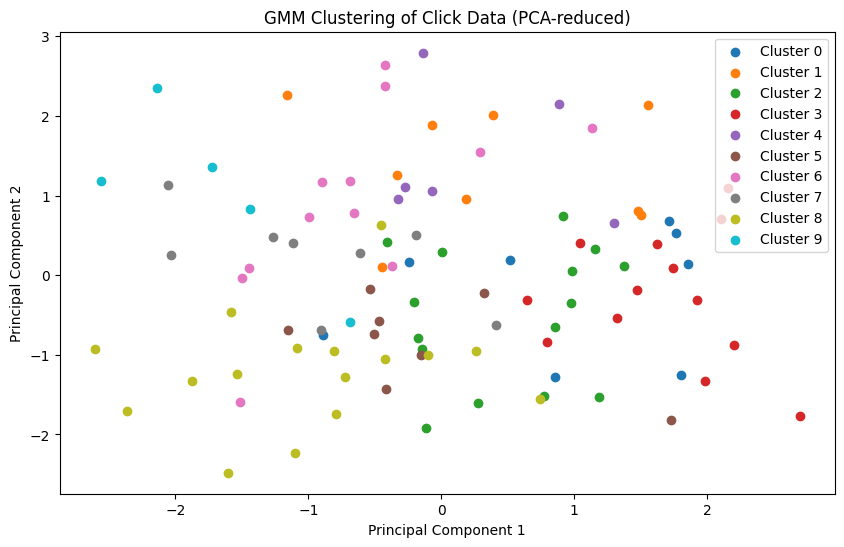

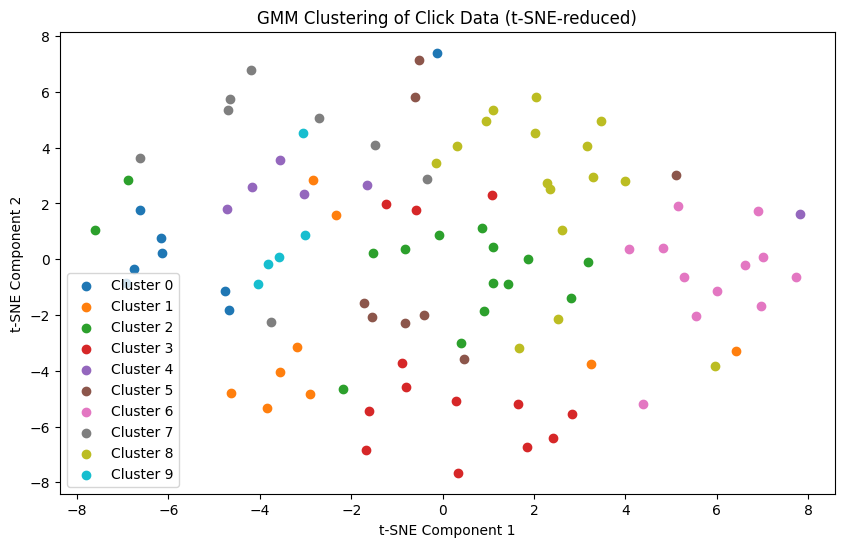

In [147]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
click_data_pca = pca.fit_transform(click_data_normalized)
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_data = click_data_pca[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')
plt.title("GMM Clustering of Click Data (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
click_data_tsne = tsne.fit_transform(click_data_normalized)
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_data = click_data_tsne[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')

plt.title("GMM Clustering of Click Data (t-SNE-reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

As we can see from t-SNE plot, data is clustered quite good :)